In [1]:
%matplotlib inline

In [2]:
import numpy as np
from nighres import io, surface
import pandas as pd
import nibabel as nb
import matplotlib.pyplot as plt
import pickle
from nipype.interfaces import fsl
from glob import glob
import os

In [3]:
def jo2allen_vol(data):
    data = np.swapaxes(np.swapaxes(data, 0,1), 1,2)
    data = np.flip(np.flip(data,1),0)
    return data

#### Make levelset from tight cortex mask (derived from layer masks)

In [ ]:
lvl=surface.probability_to_levelset("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz")
lvl['result'].to_filename("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [4]:
lvl = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

In [11]:
nb.save(nb.Nifti1Image(np.asarray(lvl.get_data(), dtype='float32'), np.eye(4)), 
        "/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz")

#### Downsample mask and levelset to 200 um

In [ ]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl.nii.gz",
                   apply_isoxfm=0.2,
                   interp="spline",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200um.nii.gz")
resamp.run()

In [35]:
resamp = fsl.FLIRT(in_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz",
                   reference="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight.nii.gz",
                   apply_isoxfm=0.2,
                   interp="nearestneighbour",
                   out_file="/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz")
resamp.run()

#### Bring original data in 200 um into allen space

In [32]:
# extract info from example image
img = nb.load("/home/julia/data/gradients/orig/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold.nii.gz")
data = img.get_data()
shape_allen = jo2allen_vol(data[:,:,:,0]).shape
num_vol = data.shape[3]

aff = np.eye(4)*0.2
aff[3,3]=1

hdr = nb.Nifti1Header()
hdr['dim']=np.array([4, shape_allen[0], shape_allen[1], shape_allen[2], num_vol, 
                     1, 1, 1], dtype='int16')
hdr['pixdim']=img.header['pixdim']


# load each image, transform and save
func = glob("/home/julia/data/gradients/orig/*MEDISO*EPI*.nii.gz")

for f in func:
    data_allen = np.zeros((shape_allen[0], shape_allen[1], shape_allen[2], num_vol))
    data_jo = nb.load(f).get_data()
    
    for vol in range(num_vol):
        data_allen[:,:,:,vol] = jo2allen_vol(data_jo[:,:,:,vol])

    nb.save(nb.Nifti1Image(data_allen, aff, hdr),
            "/home/julia/data/gradients/orig_allen/%s_allen.nii.gz" % os.path.basename(f).split(".")[0])

#### Load mesh

In [3]:
mesh = io.load_mesh_geometry("/home/julia/data/gradients/atlas/allen_api/brain_mesh.vtk")

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


(-0.5, 56.5, 39.5, -0.5)

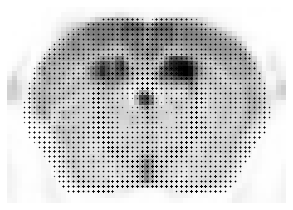

In [34]:
x = 30
fig = plt.figure(figsize=(5,5))
mesh_slice = np.floor(mesh['points'][(mesh['points'][:,0]-x*200)<1][:,1:]/200)
plt.scatter(mesh_slice[:,1], mesh_slice[:,0], s=0.1, color='black');
plt.imshow(data_allen[x, :, :,0], cmap='Greys');
plt.axis('off')

#### Load mask

In [87]:
img = nb.load("/home/julia/data/gradients/orig_allen/sub-jgrAesMEDISOc11L_ses-1_task-rest_acq-EPI_run-1_bold.nii.gz")
data = img.get_data()
mask = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz").get_data()

In [105]:
mask[mask==0]=np.nan

(-0.5, 56.5, 39.5, -0.5)

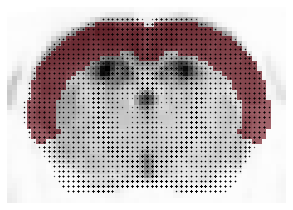

In [45]:
x = 30
fig = plt.figure(figsize=(5,5))
mesh_slice = np.floor(mesh['points'][(mesh['points'][:,0]-x*200)<1][:,1:]/200)
plt.scatter(mesh_slice[:,1], mesh_slice[:,0], s=0.1, color='black');
plt.imshow(data[x, :, :,0], cmap='Greys');
plt.imshow(mask[x, :, :], cmap='Reds_r', alpha=0.6);
plt.axis('off')

Because of imperfect alignment the upper voxels seem to not be sampled exactly, we can fix that by using the first datapoints when sampling, even at places where the mask is 0

### Sample data along levelset

In [106]:
lvl = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_lvl_200um.nii.gz").get_data()
mask = nb.load("/home/julia/data/gradients/atlas/allen_api/cortex_mask_tight_200um.nii.gz").get_data()
mask[mask==0]=np.nan

In [173]:
qa = np.zeros_like(mask)
color = 1
for p in range(0,100,10): 
    print(p)
    depth = 1
    color = color*10
    voxel = np.array(np.floor(mesh["points"][p]/200), dtype="int16")

    while True:
        
        # when outside the cortex mask
        if np.isnan(mask[voxel[0], voxel[1], voxel[2]]) == True:
            # break, unless it is the very beginning
            if depth > 2:
                break
        
        # sample at voxel
        qa[voxel[0], voxel[1], voxel[2]] = color
        
        # move voxel along descending levelset
        try:
            neighbours = lvl[voxel[0]-1:voxel[0]+2, voxel[1]-1:voxel[1]+2, voxel[2]-1:voxel[2]+2]
            min_n = np.where(neighbours==np.nanmin(neighbours))
            move = np.array([min_n[0][0]-1, min_n[1][0]-1, min_n[2][0]-1])
            if np.all(move==[0,0,0]) == True:
                break
            else:
                voxel += move
                depth +=1
                color +=1
        except ValueError:
            break
        
qa[qa==0]=np.nan

0
10
20
30
40
50
60
70
80
90


In [174]:
qa[qa==0]=np.nan

(-0.5, 56.5, 39.5, -0.5)

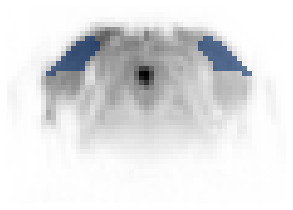

In [202]:
x = 50
fig = plt.figure(figsize=(5,5))
plt.imshow(data[x, :, :,0], cmap='Greys');
plt.imshow(mask[x, :, :], cmap='Blues_r', alpha=0.6);
plt.imshow(qa[x, :, :], cmap='cubehelix');
plt.axis('off')